In [1]:
# import libraries
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'data-test.csv') #thay đường dẫn dir đến file theo env của bạn
df.head()

,Unnamed: 0,identifier,cat1,cat2,cat3,num1,num2,num3,num4,num5,num6,num7
0,0,2fd740a40b32b6feef997679778592fc5f2fcc0dc6edec...,068f76d6,aad2e32a,920e86a2,0.014085,0.081055,NaN,0.000000,NaN,0.086552,0.125
1,1,a62d7a3afd48028af3c8984c576a48b886128e097f045a...,e400677b,aad2e32a,ec96c4d2,0.018779,0.036133,0.000022,0.142857,0.000033,0.086553,0.125
2,2,f5c43b4fd89afe8e64c8f91ca1c999064b14299b910eba...,068f76d6,aad2e32a,d81d10bd,0.089202,0.018555,0.000094,0.250000,0.000725,0.086554,0.375
3,3,c015fbd784385688219971cbc4971ce29d86730fd1d36f...,068f76d6,aad2e32a,92cd6210,0.178404,0.025391,0.000099,0.857143,0.000067,0.086554,0.125
4,4,6a3e471031592d6ffa0aec1943e345693c36e82f6dddc0...,068f76d6,69e5f75a,2bba6002,0.253521,0.032227,NaN,0.000000,NaN,NaN,0.000


# I. Summary

## Đặc điểm tổng quan của Dataset

- Dataset gồm 12 cột, 28,738 dòng.
- Cột `"Unnamed: 0"` là index, trùng khớp với `df.index`.
- Cột `"identifier"` có 28,738 giá trị unique, là ID chính cho từng entry.
- Ba cột categorical: `cat1`, `cat2` (binary) và `cat3` (10 categories).
- Bảy cột numerical: `num1` đến `num7`.
- Tỷ lệ missing data:
  - `num3` (62.83%), `num5` (41.82%), `num6` (40.42%), `num4` (8.56%), `cat1` (3.06%), `num2` (0.14%).
- Correlation giữa các biến tương đối thấp, với correlation lớn nhất là giữa `num1` và `num7` (0.39).
- Có mối liên kết rất chặt giữa missing data ở `num5` và `num6` (`null_corr ≈ 0.97`).
- Phân phối nhiều biến skewed (lệch phải hoặc trái), một số biến có nhiều giá trị gần 0 (như `num3`, `num4`, `num5`).

---

## Một số Insight ban đầu

- `cat1`, `cat2` là binary variable với tỉ lệ phân bổ khá cân bằng → có thể đại diện cho demographic features (giới tính, hôn nhân...) hoặc trạng thái tài chính (có khoản vay/thẻ tín dụng hay không).
- `cat1`, `cat2` cũng có thể là target variable cho các bài toán classification (VD: loan approval, churn).
- `cat3` với 10 category có thể đại diện cho mục đích vay vốn, phân loại vùng địa lý, hay nhóm khách hàng theo rủi ro.
- `num1` và `num7` không có missing data:
  - `num1`: dạng xác suất hoặc normalized, skewed phải.
  - `num7`: có 7 giá trị rời rạc (0 đến 0.75), có thể là ordinal variable được encode.
- `num2`: tỷ lệ thiếu thấp (0.14%), skewed rõ, có thể drop.
- `num3`, `num4`, `num5`, `num6`: tỷ lệ missing cao, phân phối không đồng đều, có outlier, cần đặc biệt xử lý kỹ.

---

## Các vấn đề chính và hướng xử lý đề xuất

### Missing Data
- **`cat1` (3.06%)**:
  - Có thể drop do tỷ lệ nhỏ.
  - Hoặc gán `'Không tiết lộ'` như một nhóm riêng.
  - Hoặc impute bằng mode theo nhóm (`groupby` theo `cat2` hoặc bin của `num1`).
  - Nếu cần, có thể dùng mô hình để dự đoán (nếu là target).

- **`num2` (0.14%)**:
  - Có thể drop hàng bị thiếu mà không ảnh hưởng đáng kể.

- **`num3`, `num4`, `num5`, `num6`**:
  - Do tỷ lệ thiếu lớn → ưu tiên dùng các phương pháp Imputation phức tạp:
    - `IterativeImputer` (dựa vào hồi quy, phù hợp khi có nhiều missing data).
    - `KNNImputer` (tận dụng mối quan hệ cục bộ giữa các hàng).
    - Tree-based model (XGBoost, LightGBM...) có thể xử lý NaN mà không cần pre-impute.
    - Không khuyến khích `SimpleImputer` hoặc drop cột do sẽ mất thông tin đáng kể.

### Phân phối dữ liệu
- Phân phối nhiều cột bị skew, cần cân nhắc scale/log transform nếu sử dụng cho mô hình.
- Một số biến có nhiều giá trị bằng 0 → có thể là zero-inflated → cần chú ý khi chọn mô hình dự đoán.

## II. Quá trình EDA chi tiết

## 1. Data overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28738 entries, 0 to 28737
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  28738 non-null  int64  
 1   identifier  28738 non-null  object 
 2   cat1        27858 non-null  object 
 3   cat2        28738 non-null  object 
 4   cat3        28738 non-null  object 
 5   num1        28738 non-null  float64
 6   num2        28697 non-null  float64
 7   num3        10681 non-null  float64
 8   num4        26277 non-null  float64
 9   num5        16720 non-null  float64
 10  num6        17122 non-null  float64
 11  num7        28738 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 2.6+ MB


In [4]:
(df['Unnamed: 0'] == df.index).all()

np.True_

In [5]:
column_summary = pd.DataFrame({
    'Data Type': df.dtypes,
    'Null Count': df.isnull().sum(),
    'Null Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Unique Count': df.nunique()
})
print(column_summary)

           Data Type  Null Count  Null Percentage  Unique Count
Unnamed: 0     int64           0             0.00         28738
identifier    object           0             0.00         28738
cat1          object         880             3.06             2
cat2          object           0             0.00             2
cat3          object           0             0.00            10
num1         float64           0             0.00           214
num2         float64          41             0.14            93
num3         float64       18057            62.83          1253
num4         float64        2461             8.56            29
num5         float64       12018            41.82          1319
num6         float64       11616            40.42            68
num7         float64           0             0.00             7


Cái nhìn đầu tiên về dataset và các variables bằng df.info() và các function liên quan, ta nắm được các thông tin cơ bản sau:
- Shape: Dataset có 7 cột, và 28738 data entry
- Cột "Unnamed: 0" thực chất là cột index: data type int64, đã so sánh và boolean check với df.index
- Cột "identifier" với 28738 unique value là id/primary key của từng entry
- Các cột còn lại (cat1 đến cat3, num1 đến num7) là variables, trong đó: Các cột cat1, cat2, cat3 là category data với cat1, cat2 là binary category, còn cat3 có 10 categories. Các cột từ num1 đến num7 là numerical data.
- Dataset có vấn đề về missing data, với tỉ lệ missing data ở các variable lần lượt là: num3 (62.83%), num5 (41,82%), num6 (40,42%), num4(8.56%), cat1 (3.06%), và num2 (0.14%). Với tỉ lệ missing data lớn thế này, bắt buộc phải tìm phương án impute/ bổ sung dữ liệu, trừ trường hợp missing data ở num2 có thể drop do có tỉ lệ nhỏ.
- Tạo correlation heatmap cho thấy các cột dữ liệu tương đối độc lập và không có tương quan với nhau

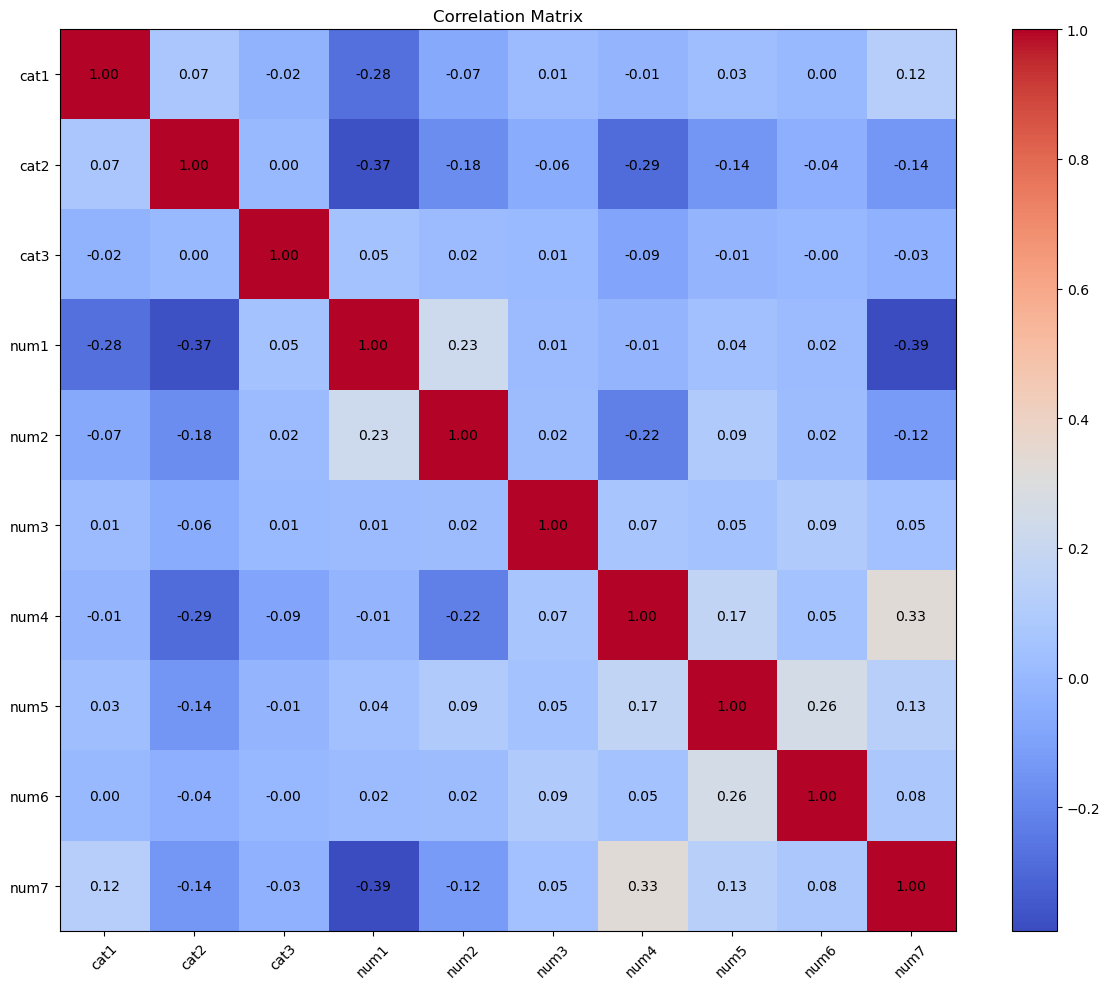

In [6]:
# Correlation matrix
cols_for_corr = ['cat1', 'cat2', 'cat3', 'num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7']
df_corr = df[cols_for_corr]
for col in ['cat1', 'cat2', 'cat3']:
    df_corr[col] = pd.factorize(df[col])[0]
corr_matrix = df_corr.corr()

# Correlation heatmap
plt.figure(figsize=(12, 10))
heatmap = plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(heatmap)
for i in range(len(cols_for_corr)):
    for j in range(len(cols_for_corr)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center')

plt.xticks(range(len(cols_for_corr)), cols_for_corr, rotation=45)
plt.yticks(range(len(cols_for_corr)), cols_for_corr)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## 2. Category data

In [7]:
cat_cols = ['cat1', 'cat2', 'cat3']
num_cols = ['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7']

# Tạo dict gồm các df chứa unique value count và tỉ lệ unique value của từng cột category
value_counts = {col: df[col].value_counts(dropna=False).to_frame(name='Count') for col in cat_cols}
for col in value_counts:
    value_counts[col]['%'] = ((value_counts[col]['Count'] / df.shape[0]) * 100).round(2)

value_counts

{'cat1':           Count      %
 cat1                  
 068f76d6  15423  53.67
 e400677b  12435  43.27
 NaN         880   3.06,
 'cat2':           Count      %
 cat2                  
 69e5f75a  17171  59.75
 aad2e32a  11567  40.25,
 'cat3':           Count      %
 cat3                  
 ec96c4d2   4445  15.47
 2bba6002   4304  14.98
 920e86a2   4088  14.23
 92cd6210   3770  13.12
 c73723a0   2888  10.05
 d81d10bd   2721   9.47
 f26f7527   2518   8.76
 39f59ba0   1970   6.86
 56094e6f   1751   6.09
 8f4950e2    283   0.98}

Với category data (tất cả các value đã được mã hóa):
- cat1, cat2 là binary category variable, với tỉ lệ phân bổ khá đồng đều. Đây có thể là independent variable về demographic: giới tính, tình trạng hôn nhân (kết hôn/độc thân), có con hay chưa,... Hoặc dữ liệu liên quan đến tài chính: high income/low income, có khoản vay/thẻ tín dụng hay chưa, có nhà/ko có nhà,...
- cat1, cat2 cũng có thể là target variables trong bài toán classifier: loan approval, churn or not
- cat3 với 10 unique value và không missing data có thể là independent variable về: mục đích vay, xếp hạng rủi ro, xếp hạng tín dụng, vùng địa lý, giỏ thu nhập,

Về xử lí missing data của cat1 (3% missing data), do value của cat1 đã mã hóa, khó có thể xác định được loại missing data có random hay ko, xin được đưa ra các phương án xử lí như sau:
- Drop entry có missing data (tỉ lệ missing data < 5% có thể chấp nhận dropping)
- Coi missing data là 1 category riêng: ví dụ như gender có những người sẽ không muốn chia sẻ, tương tự với high/low income
```
    df['cat1'].fillna('Không tiết lộ', inplace=True)
```
- Impute giá trị có tần xuất nhiều nhất, dựa trên việc nhóm các data entry bằng variable khác. Chọn variable để group by phụ thuộc vào tương quan giữa groupby-variable và cat1, tương quan càng lớn càng tốt (hướng tương quan ko quan trọng). Dựa vào correlation matrix ở trên, có thể lấy ví dụ impute cat1 theo cat2 hoặc num1 như sau:
```
# Với category variable như cat2, impute missing data theo mode của cat1 trong mỗi category của cat2:
df['cat1'] = df.groupby('cat2')['cat1'].transform(lambda x: x.fillna(x.mode()[0]))

# Với numerical data như num1, thì tạo bin rồi impute theo mode của cat1 trong mỗi bin ()
df['num1_bin'] = pd.qcut(df['num1'], q=4, duplicates='drop')
df['cat1'] = df.groupby('num1_bin')['cat1'].transform(lambda x: x.fillna(x.mode()[0]))
```

- Impute bằng mode của bản thân cat1 (value 068f76d6): phương pháp đơn giản nhưng cần cân nhắc kĩ nội dung của cat1 khi áp dụng cách xử lí này có gây sai lệch về 1 nhóm không
- Dùng model để dự đoán missing data cat1, phù hợp nếu cat1 là target variable, tuy nhiên nếu cat1 chỉ là independent variable thì phương pháp này là overkill cho data processing.


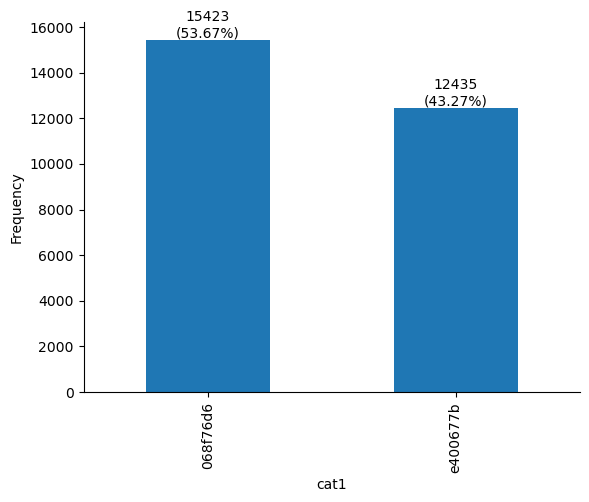

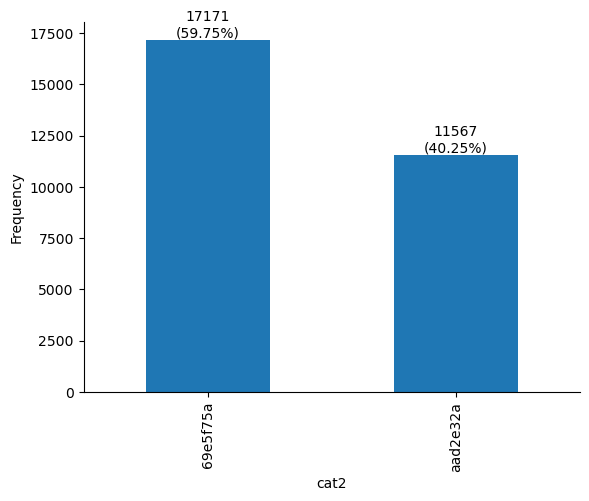

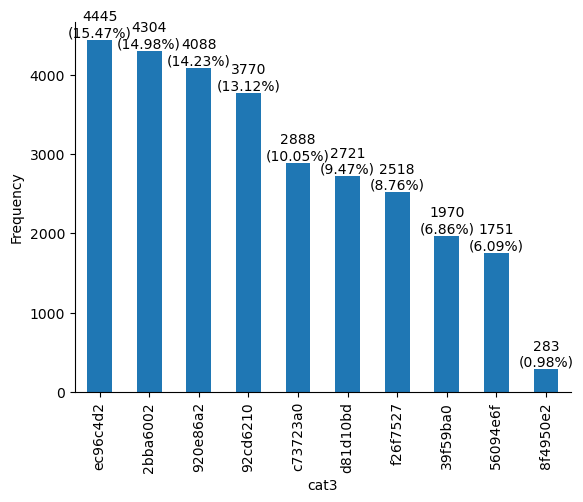

In [8]:
for col in cat_cols:
    value_counts = df[col].value_counts()
    fig, ax = plt.subplots()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    value_counts.plot(kind='bar', ax=ax)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    for i, v in enumerate(value_counts):
        proportion = (v / df.shape[0]) * 100
        ax.text(i, v + 0.5, f'{v}\n({proportion:.2f}%)', ha='center', va='bottom')
    plt.show()

## 3. Numerical variable

In [9]:
df_num = df[num_cols]
print(df_num.describe())

               num1          num2          num3          num4          num5  \
count  28738.000000  28697.000000  10681.000000  26277.000000  16720.000000   
mean       0.188633      0.032565      0.000325      0.179564      0.000177   
std        0.168857      0.013316      0.004228      0.284425      0.000737   
min        0.000000      0.002930      0.000000      0.000000      0.000023   
25%        0.093897      0.021484      0.000012      0.000000      0.000023   
50%        0.150235      0.030273      0.000053      0.000000      0.000027   
75%        0.211268      0.041016      0.000168      0.321429      0.000080   
max        1.000000      0.107422      0.333525      1.000000      0.049538   

               num6          num7  
count  17122.000000  28738.000000  
mean       0.086554      0.127740  
std        0.000010      0.070758  
min        0.085562      0.000000  
25%        0.086553      0.125000  
50%        0.086553      0.125000  
75%        0.086554      0.125000  


In [10]:
column_summary = pd.DataFrame({
    'Data Type': df_num.dtypes,
    'Null Count': df_num.isnull().sum(),
    'Null Percentage': (df_num.isnull().sum() / len(df) * 100).round(2),
    'Unique Count': df_num.nunique()
})
print(column_summary)

     Data Type  Null Count  Null Percentage  Unique Count
num1   float64           0             0.00           214
num2   float64          41             0.14            93
num3   float64       18057            62.83          1253
num4   float64        2461             8.56            29
num5   float64       12018            41.82          1319
num6   float64       11616            40.42            68
num7   float64           0             0.00             7


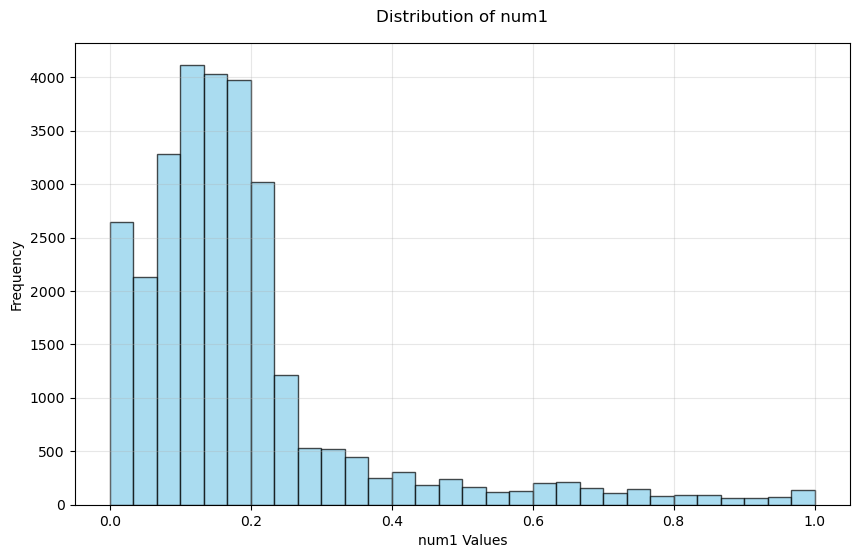

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(df['num1'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of num1', fontsize=12, pad=15)
plt.xlabel('num1 Values', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

Cột `num1` không có missing data, có normal distribution với range từ 0.0 đến 1.0, right skew, với mean ~ 0.19 và std xấp xỉ 0.17. Dữ liệu này có thể là dữ liệu phần trăm, xác xuất hành vi, hoặc dữ liệu có min max đã được normalized.

Cột `num7` cũng không có missing data, có 7 unique value từ 0 đến 0.75 với step 0.125 và mode ở 0.125. Đây có thể là ordinal category data (dữ liệu nhóm có xếp hạng) được encode thành số để thể hiện thứ tự. Ví dụ như xếp hạng độ rủi ro của khách hàng, hoặc xếp hạng tín dụng. Có thể xử lí nhóm này như 1 categorical data trong model bằng cách label encoding.

In [12]:
num_7 = df['num7'].value_counts().to_frame(name='Count')
num_7['Percentage'] = (num_7['Count'] / len(df) * 100).round(2)
num_7 = num_7.sort_index()
print(num_7)

       Count  Percentage
num7                    
0.000   3807       13.25
0.125  20929       72.83
0.250   3612       12.57
0.375    353        1.23
0.500     30        0.10
0.625      6        0.02
0.750      1        0.00


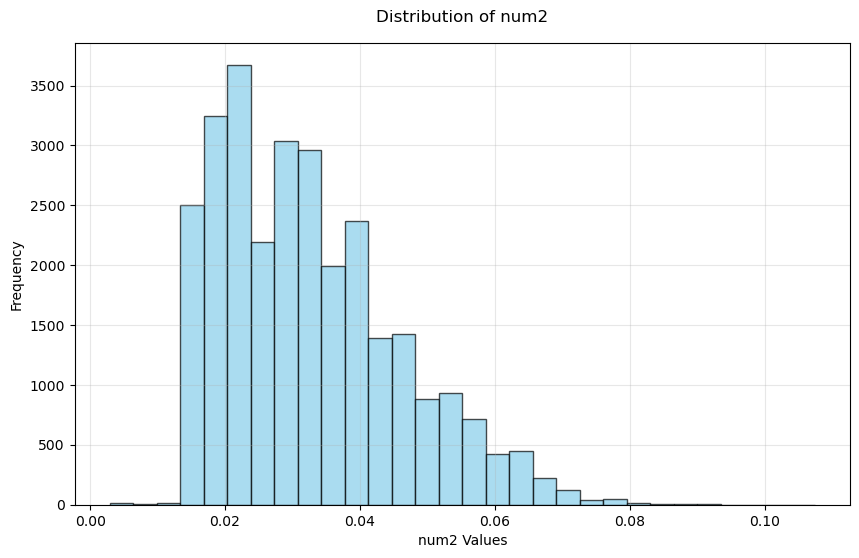

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df['num2'].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of num2', fontsize=12, pad=15)
plt.xlabel('num2 Values', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

`num2` là một biến dạng số thực, có tỷ lệ missing data nhỏ (0.14%) nên có thể drop các dòng bị thiếu mà không ảnh hưởng đáng kể đến dataset. Phân phối của biến này nghiêng phải rõ rệt, với phần lớn giá trị tập trung ở khoảng thấp từ khoảng 0.0029 đến 0.04, trong khi giá trị lớn nhất là khoảng 0.107. Giá trị trung bình là 0.032 và trung vị là 0.030, cho thấy phân phối hơi lệch về phía phải. Biến này có thể đại diện cho một loại tỷ lệ hoặc chỉ số hiệu suất nào đó được chuẩn hóa trong khoảng nhỏ. Do có phân phối lệch và một vài giá trị cao hơn hẳn phần lớn dữ liệu, cần lưu ý kiểm tra và xử lý outlier nếu dùng biến này trong các phân tích sâu hơn hoặc mô hình dự đoán.

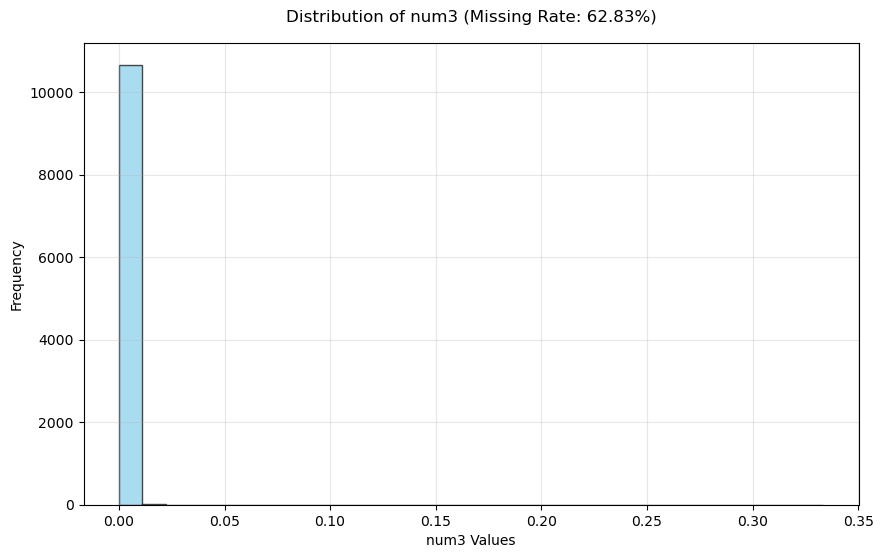

count    10681.000000
mean         0.000325
std          0.004228
min          0.000000
25%          0.000012
50%          0.000053
75%          0.000168
max          0.333525
Name: num3, dtype: float64


In [14]:
plt.figure(figsize=(10, 6))
plt.hist(df['num3'].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of num3 (Missing Rate: 62.83%)', fontsize=12, pad=15)
plt.xlabel('num3 Values', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()
print(df_num['num3'].describe())

Cột `num3` có tỷ lệ thiếu data cao nhất 62.8%. Xét phần data không bị thiếu, biến này có phân phối nghiêng mạnh về bên trái, với phần lớn giá trị gần bằng 0 (25-50-75 quantile lần lượt là 0.000012, 0.000053, 0.000168). Giá trị trung bình và trung vị của biến đều rất nhỏ nằm ở mức gần 0, nhưng có một vài outlier kéo dài đuôi phân phối. Độ lệch chuẩn nhỏ, nhưng số unique value lớn (1253), có thể đây là một biến định lượng liên tục.

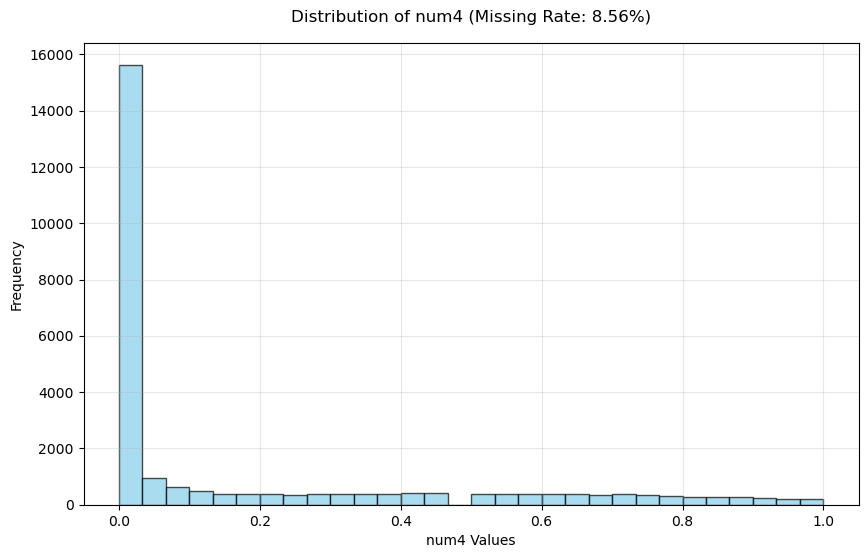

count    26277.000000
mean         0.179564
std          0.284425
min          0.000000
25%          0.000000
50%          0.000000
75%          0.321429
max          1.000000
Name: num4, dtype: float64


In [15]:
plt.figure(figsize=(10, 6))
plt.hist(df['num4'].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of num4 (Missing Rate: 8.56%)', fontsize=12, pad=15)
plt.xlabel('num4 Values', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

print(df_num['num4'].describe())

`num4` có tỷ lệ thiếu data ở mức 8.6%. Biến này có phân phối rất không đồng đều với median bằng 0, cho thấy hơn một nửa số quan sát có `num4` bằng 0. Tuy nhiên, mean khá cao (≈ 0.18), phản ánh rằng một phần không nhỏ các quan sát còn lại có giá trị lớn hơn đáng kể, kéo theo độ lệch chuẩn cao (≈ 0.28) và giá trị tối đa đạt đến 1.0. Phân phối này gợi ý rằng `num4` là một biến dạng tỷ lệ hoặc tỷ trọng, trong đó phần lớn các quan sát không có giá trị (bằng 0), nhưng một số ít lại có giá trị lớn. Cần chú ý khi sử dụng biến này trong phân tích vì sự mất cân đối giữa các giá trị có thể ảnh hưởng đến kết quả mô hình nếu không được xử lý phù hợp.

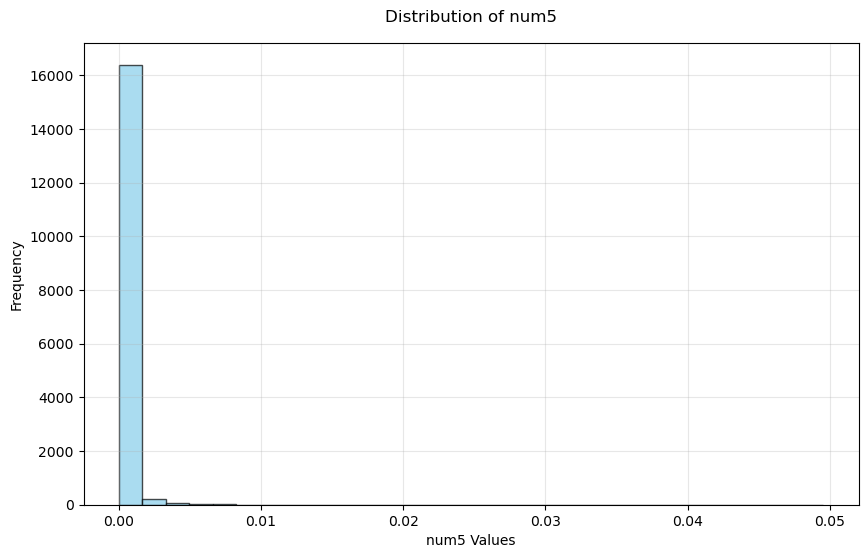

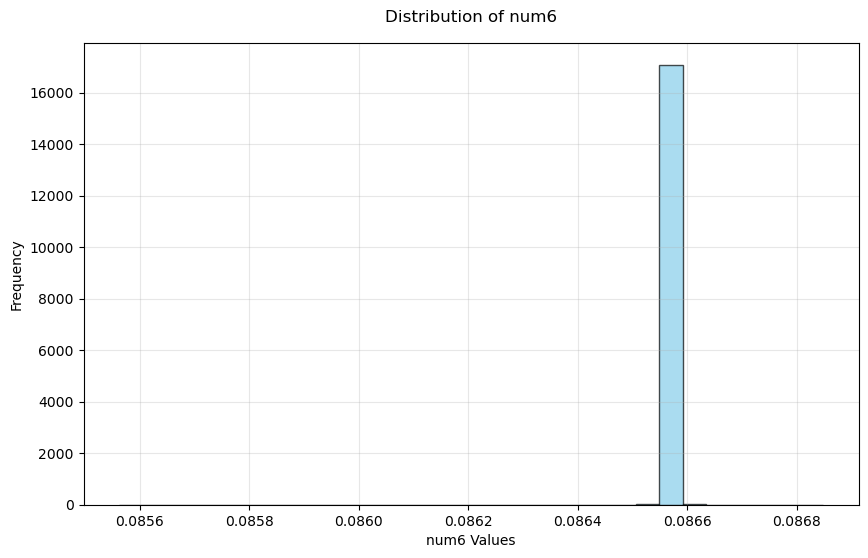

               num5          num6
count  16720.000000  17122.000000
mean       0.000177      0.086554
std        0.000737      0.000010
min        0.000023      0.085562
25%        0.000023      0.086553
50%        0.000027      0.086553
75%        0.000080      0.086554
max        0.049538      0.086849


In [16]:
plt.figure(figsize=(10, 6))
plt.hist(df['num5'].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of num5', fontsize=12, pad=15)
plt.xlabel('num5 Values', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['num6'].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of num6', fontsize=12, pad=15)
plt.xlabel('num6 Values', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()


print(df_num[['num5', 'num6']].describe())

`num5` và `num6` đều có tỷ lệ thiếu dữ liệu tương đối cao, lần lượt là 41.8% và 40.4%. Cả hai cột này thể hiện mối tương quan rất mạnh về missing data với hệ số correlation khi có missing data lên đến 0.97, cho thấy rằng tình trạng thiếu data ở `num5` và `num6` thường xảy ra đồng thời. 
- Về mặt phân phối, `num5` có mean là 0.000177, median là 0.000027, quantile 25-75% nhỏ tập trung quanh median nhưng std và max lại khá lớn so với median, cho thấy có outlier. 
- `num6` có mean là 0.086554, median là 0.086553 và std cực kỳ nhỏ (0.000010), thể hiện giá trị `num6` tập trung quanh một giá trị cố định gần như không thay đổi. Dựa trên các thống kê này, `num6` nhiều khả năng là một biến đo lường có dao động rất nhỏ gần

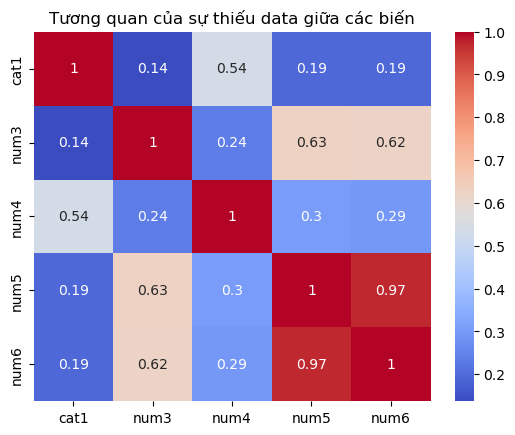

In [17]:
# Dựng heatmap thể hiện tương quan giữa việc thiếu data của các biến
null_df = df[['cat1','num3','num4','num5','num6']].isnull()
null_corr = null_df.corr()
sns.heatmap(null_corr, annot=True, cmap='coolwarm')
plt.title("Tương quan của sự thiếu data giữa các biến")
plt.show()


## 4. Mising data handling

Các cột `num3`, `num4`, `num5`, `num6` đều có tỷ lệ missing cao, đặc biệt `num3` (62.8%) và `num5`, `num6` (trên 40%). Ngoài ra, theo null heatmap, `num5` và `num6` có tương quan NaN rất cao (`null_corr ≈ 0.97`), gợi ý khả năng tồn tại pattern chung trong missing data.

Xin phép được đưa ra các phương án xử lí dữ liệu bị thiếu, xếp thứ tự theo đánh giá cá nhân về độ hợp lí với data-test:

**`IterativeImputer`** 
Gần giống với MICE - Multiple Imputation by Chained Equations, IterativeImputer dự đoán các giá trị bị thiếu tại 1 biến n bằng mô hình hồi quy với các biến còn lại làm input feature.
   - Ưu: Tận dụng thông tin từ nhiều biến. Đặc biệt phù hợp nếu có tương quan giữa các biến, có thể tự động phát hiện pattern để dự đoán giá trị thiếu. Hoạt động tốt hơn Imputing kiểu đơn giản bằng số liệu thống kê khi tỉ lệ missing data cao
   - Nhược: dễ bị overfit, có thể converge chậm hơn
    ```
    # code ví dụ cho IterativeImputer
    cols_to_impute = ['num3', 'num4', 'num5', 'num6']
    df_impute = df[cols_to_impute].copy()
    iter_imputer = IterativeImputer(random_state=0, max_iter=10)
    df_iter_imputed = pd.DataFrame(
    iter_imputer.fit_transform(df_impute),
    columns=cols_to_impute,
    index=df_impute.index)
    ```

**`KNNImputer`**
Impute bằng KNN, hiểu đơn giản là điền vào giá trị bị thiếu giá trị trung bình của cột đó lấy từ K hàng có khoảng cách gần nhất. 
   - Ưu: Thay thế tốt cho `IterativeImputer` với các ưu điểm tương tự. Giữ được mối quan hệ cục bộ giữa các quan sát, nhất là khi dữ liệu không tuyến tính.
   - Nhược: nhạy cảm với outlier và scale của data
    ```
    #code ví dụ sử dụng KNN để impute data bị thiếu
    knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
    df_knn_imputed = pd.DataFrame(
    knn_imputer.fit_transform(df_impute),
    columns=cols_to_impute,
    index=df_impute.index)
    ```

**Sử dụng mô hình hỗ trợ NaN: tree-based models**
Các mô hình thuộc nhóm Decision tree bẻ nhánh theo threshold của numerical data, và với dữ liệu thiếu (NaN) các mô hình này coi nó là 1 nhánh riêng biệt, do đó không cần phải xử lí missing data trước khi train model.
   - Ưu: không phải pre-processing, có thể xử dụng các phương pháp kết hợp mô hình (emsemble method) dựa trên decision tree
   - Nhược: Giới hạn trong các model phát triển từ decision tree

**`SimpleImputer` hoặc Drop cột**
   SimpleImputer đơn giản là thay thế giá trị bị thiếu bằng 1 giá trị constant nào đó trong các giá trị thống kê như: mean, min, max, median. Phương pháp này hoặc drop cột đều có độ ưu tiên thấp trong dataset này do có nhược điểm sau:
   - Nhược: Drop cột có thể gây mất thông tin quan trọng, trong khi đó SimpleImputer quá đơn giản, không xét đến môis quan hệ giữa các variable và có thể gây sai lệch nếu missing data nhiều và phân phối có skew như các cột num3, num5, num6
   - Ưu: nhanh, đơn giản